# 前回からの課題
- 複数回繰り返す前処理は関数化して管理しやすくする
- state=live, suspendedを除去
- 多数決は >=3 にする

# 方針
- 線形モデル
- 決定木モデル
- ニューラルネットワーク

のモデルそれぞれで前処理とテストを行う

In [1]:
# 共通パッケージ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Data process
from sklearn.model_selection import KFold, train_test_split
# Metrics
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [4]:
# データの読み込み
df = pd.read_csv('./data/ks-projects-201801.csv')
print(df.shape)
df.head()

(378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# 前処理共通部分
- 目的変数のノイズレコードを除去
- launched to deadline を日数に変換
- objectをサンプル数の少ないデータをothersにまとめて、カテゴリカル変数に変換

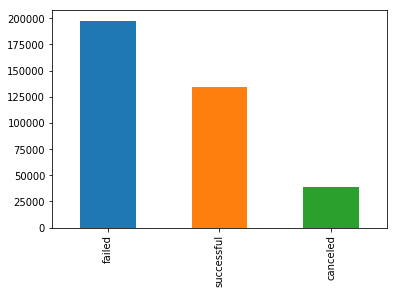

In [22]:
# 目的変数の可視化
display(df.state.value_counts().plot.bar())

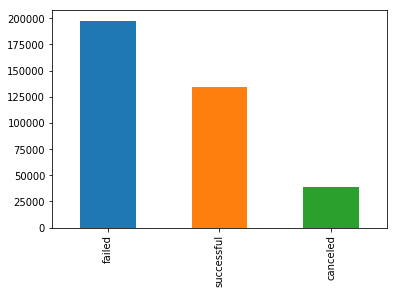

In [23]:
# 目的変数の条件を指定する
df['state'] = df['state'].apply(lambda x: x if x not in set(['live', 'undefined', 'suspended']) else None)
df['state'].value_counts().plot.bar()

In [24]:
# データフレーム全体に反映させる
dropped_df = df.dropna()
display(df.shape)
display(dropped_df.shape)

(378661, 15)

(370219, 15)

In [25]:
# ID のドロップ
dropped_df = dropped_df.drop('ID', axis=1)
display(dropped_df.shape)
dropped_df.head()

(370219, 14)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


0    False
1    False
2    False
3    False
4    False
Name: state, dtype: bool

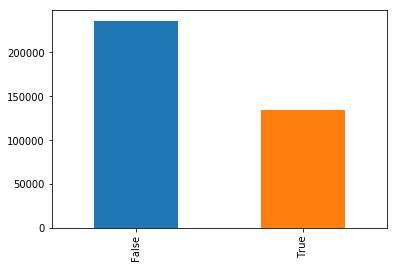

In [26]:
# successful or failed の二値化
y_bool = dropped_df['state'] == 'successful'
display(y_bool.head())
y_bool.value_counts().plot.bar()

In [27]:
dropped_use_df = dropped_df[['category', 'main_category', 'currency', 'deadline', 'country', 'goal', 'launched']]
dropped_use_df.columns

Index(['category', 'main_category', 'currency', 'deadline', 'country', 'goal',
       'launched'],
      dtype='object')

## days

In [28]:
# 日付をまとめる
# 日付データに変更
df_date = pd.DataFrame()
for name in ['deadline', 'launched']:
    df_date[name] = pd.to_datetime(dropped_use_df[name])

# 日付の差分を取る
df_days = df_date['deadline'] - df_date['launched']
df_days.name = 'days'
# 日数に変更
df_days = df_days.astype('timedelta64[D]')
df_days.head()

0    58.0
1    59.0
2    44.0
3    29.0
4    55.0
Name: days, dtype: float64

## main_category

Film & Video    62247
Music           49101
Publishing      39014
Games           34719
Technology      31761
Design          29515
Art             27862
Food            24263
Fashion         22424
Theater         10850
Comics          10720
Photography     10675
Crafts           8661
Journalism       4671
Dance            3736
Name: main_category, dtype: int64

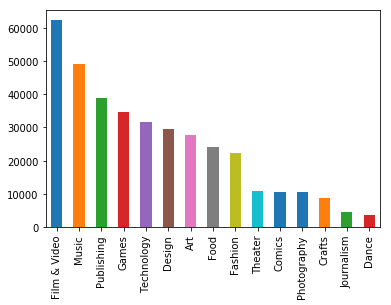

In [30]:
# main_category
display(dropped_use_df.main_category.value_counts())
dropped_use_df.main_category.value_counts().plot.bar()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'others',
       'Games', 'Fashion', 'Art', 'Technology'], dtype=object)

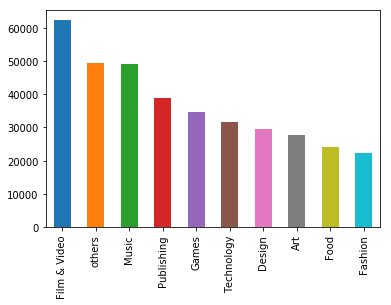

In [31]:
# しきい値より低い値を'others'にまとめる
main_cate_thread = 15000
main_cate_dict = dropped_use_df.main_category.value_counts().to_dict()
main_cate_df = dropped_use_df.main_category.apply(lambda x: x if main_cate_dict[x] > main_cate_thread else 'others')
display(main_cate_df.unique())
main_cate_df.value_counts().plot.bar()

## currency

USD    289669
GBP     33214
EUR     16743
CAD     14508
AUD      7681
SEK      1718
MXN      1632
NZD      1425
DKK      1083
CHF       736
NOK       694
HKD       564
SGD       521
JPY        31
Name: currency, dtype: int64

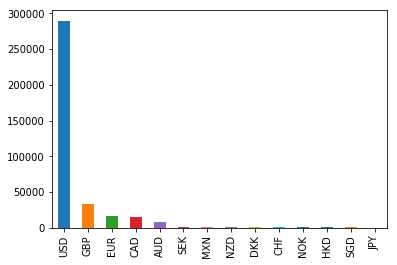

In [32]:
# currency
display(dropped_use_df.currency.value_counts())
dropped_use_df.currency.value_counts().plot.bar()

array(['GBP', 'USD', 'CAD', 'AUD', 'others', 'EUR'], dtype=object)

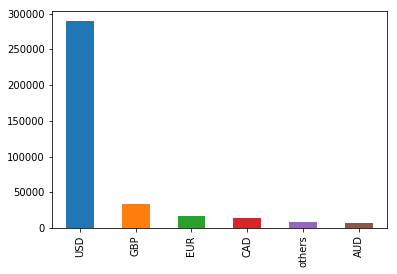

In [33]:
# しきい値より低い値を'others'にまとめる
currency_thread = 7000 # AUD以下
currency_dict = dropped_use_df.currency.value_counts().to_dict()
currency_df = dropped_use_df.currency.apply(lambda x: x if currency_dict[x] > currency_thread else 'others')
display(currency_df.unique())
currency_df.value_counts().plot.bar()

## country

US    289669
GB     33214
CA     14508
AU      7681
DE      4057
FR      2873
NL      2807
IT      2775
ES      2204
SE      1718
MX      1632
NZ      1425
DK      1083
IE       793
CH       736
NO       694
BE       597
AT       576
HK       564
SG       521
LU        61
JP        31
Name: country, dtype: int64

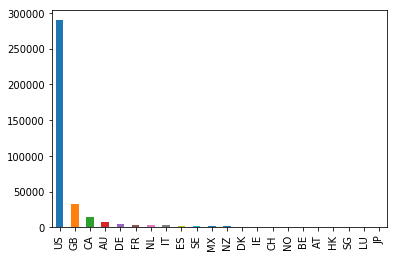

In [36]:
# country
display(dropped_use_df.country.value_counts())
dropped_use_df.country.value_counts().plot.bar()

array(['GB', 'US', 'CA', 'AU', 'others'], dtype=object)

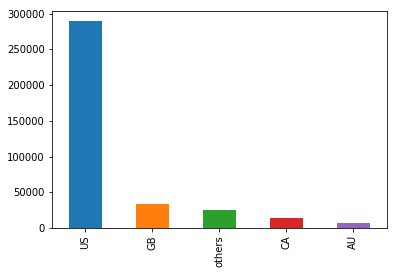

In [37]:
# しきい値より低い値を'others'にまとめる
country_thread = 7000 # AUD以下
country_dict = dropped_use_df.country.value_counts().to_dict()
country_df = dropped_use_df.country.apply(lambda x: x if country_dict[x] > country_thread else 'others')
display(country_df.unique())
country_df.value_counts().plot.bar()

## category

Product Design       21886
Documentary          16065
Tabletop Games       14036
Music                13208
Shorts               12303
Video Games          11689
Food                 11395
Film & Video          9149
Fiction               9107
Fashion               8474
Nonfiction            8259
Art                   8155
Theater               7036
Apparel               7029
Technology            6742
Rock                  6717
Children's Books      6711
Apps                  6239
Webseries             5735
Photography           5729
Indie Rock            5639
Publishing            5452
Narrative Film        5168
Web                   5055
Comics                4973
Crafts                4603
Country & Folk        4428
Design                4122
Hip-Hop               3853
Hardware              3590
                     ...  
Couture                268
Blues                  265
Animals                247
Fabrication Tools      242
Printing               236
Makerspaces            235
M

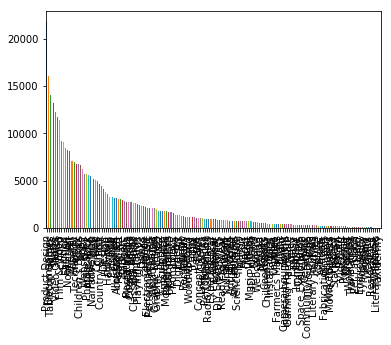

In [38]:
# category
display(dropped_use_df.category.value_counts())
dropped_use_df.category.value_counts().plot.bar()

array(['Poetry', 'Narrative Film', 'Music', 'Film & Video', 'Restaurants',
       'Food', 'Drinks', 'Product Design', 'Documentary', 'Nonfiction',
       'Indie Rock', 'Crafts', 'Games', 'Tabletop Games', 'Design',
       'Comic Books', 'Art Books', 'Fashion', 'Others', 'Theater',
       'Comics', 'DIY', 'Webseries', 'Animation', 'Food Trucks',
       'Public Art', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Fiction', 'Accessories', 'Rock', 'Hardware', 'Software',
       'Gadgets', 'Web', 'Jazz', 'Ready-to-wear', 'Festivals',
       'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Electronic Music', 'Radio & Podcasts', 'Apps', 'Apparel',
       'Comedy', 'Hip-Hop', 'Periodicals', 'Dance', 'Technology',
       'Painting', 'World Music', 'Photobooks', 'Drama', 'Architecture',
       'Young Adult', 'Mobile Games', 'Fine Art', 'Action',
       'Playing Cards', "Children's Books", 'Performance Art',
       'Graphic Novels', 'Performances', 'Sculpture', 'Thril

(95,)

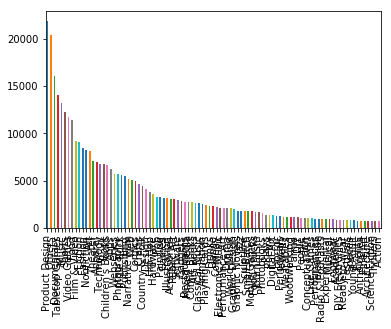

In [41]:
# しきい値より低い値を'others'にまとめる
cate_thread = 727
cate_dict = dropped_use_df.category.value_counts().to_dict()
cate_df = dropped_use_df.category.apply(lambda x: x if cate_dict[x] > cate_thread else 'Others')
display(cate_df.unique())
display(cate_df.unique().shape)
cate_df.value_counts().plot.bar()

## 最終的な共通前処理終了

In [65]:
# 全部をまとめる <category, main_category, currency, country>
common_df = pd.concat([cate_df, main_cate_df, currency_df, country_df, dropped_use_df['goal'], df_days], axis=1)
common_df.head()

,category,main_category,currency,country,goal,days
0,Poetry,Publishing,GBP,GB,1000.0,58.0
1,Narrative Film,Film & Video,USD,US,30000.0,59.0
2,Narrative Film,Film & Video,USD,US,45000.0,44.0
3,Music,Music,USD,US,5000.0,29.0
4,Film & Video,Film & Video,USD,US,19500.0,55.0


In [55]:
# objectをカテゴリカルに変換
for column in ['category', 'main_category', 'currency', 'country']:
    labels, uniques = pd.factorize(common_df[column])
    common_df[column] = labels

In [57]:
common_df.head()

,category,main_category,currency,country,goal,days
0,0,0,0,0,1000.0,58.0
1,1,1,1,1,30000.0,59.0
2,1,1,1,1,45000.0,44.0
3,2,2,1,1,5000.0,29.0
4,3,1,1,1,19500.0,55.0


# 共通前処理データの保存

In [58]:
common_df.to_csv('./data/common_preprocess.csv', index=None)

# モデルごとの前処理構築方針
- 線形モデル：カテゴリカル変数をone-hotベクトル化 & goalとdaysを標準化
- 決定木モデル：このままのデータを使用
- ニューラルネットワーク：線形モデルと同じ

# 線形モデルの前処理

In [71]:
# カテゴリカルな説明変数をone hot に変換
onehot_std_df = pd.get_dummies(common_df, columns=['category', 'main_category', 'currency', 'country'])
onehot_std_df.head()

,goal,days,category_Academic,category_Accessories,category_Action,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,...,currency_CAD,currency_EUR,currency_GBP,currency_USD,currency_others,country_AU,country_CA,country_GB,country_US,country_others
0,1000.0,58.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,30000.0,59.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,45000.0,44.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,5000.0,29.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,19500.0,55.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [72]:
# goal, daysを標準化
# 標準化
from sklearn.preprocessing import StandardScaler

In [73]:
stdsc = StandardScaler()
onehot_std_df['days'] = stdsc.fit_transform(onehot_std_df['days'].values.reshape(-1,1))
onehot_std_df['goal'] = stdsc.fit_transform(onehot_std_df['goal'].values.reshape(-1,1))
onehot_std_df.head()

,goal,days,category_Academic,category_Accessories,category_Action,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,...,currency_CAD,currency_EUR,currency_GBP,currency_USD,currency_others,country_AU,country_CA,country_GB,country_US,country_others
0,-0.041077,0.405093,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,-0.016082,0.421565,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,-0.003154,0.174479,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.037630,-0.072607,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,-0.025132,0.355675,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## 線形モデル、ニューラルネットワークの前処理終了
# 各モデルの学習
# 1. 線形モデル

In [75]:
# sklearn Model
from sklearn.linear_model import SGDClassifier

## データの分割

In [76]:
X = onehot_std_df.values
y = y_bool.values.astype(int) * 1
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(296175, 118)

(74044, 118)

(296175,)

(74044,)

## 線形モデルの学習の実行

In [77]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_log_like = 0
cross_valid_acc = 0
split_num = 1

# 検証役を交代させながら学習と評価を繰り返す
regr = []
# 配列の定義
y_pred_test = np.empty((len(X_test), n_split))

for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_split, random_state=None).split(X_train)):
    train_x, train_y = X_train[train_idx], y_train[train_idx] #学習用データ
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]     #検証用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr.append(SGDClassifier(loss="log", penalty="none", max_iter=100, fit_intercept=False))
    regr[i].fit(train_x, train_y)

    # 検証データに対する予測を実行
    y_pred_valid = regr[i].predict(valid_x)
    
    # 検証データに対する対数尤度を計算
    log_like = - log_loss(valid_y, y_pred_valid)
    acc = accuracy_score(valid_y, y_pred_valid)
    print("Fold %s"%split_num)
    print("対数尤度 = %s"%round(log_like, 3))
    print('正答率 = {:.3f}%'.format(100 * acc))
    print()
    
    cross_valid_log_like += log_like #後で平均を取るためにLog Likelihoodを加算
    cross_valid_acc += 100 * acc
    split_num += 1
    
    # テストデータの予測
    # 配列の列方向に予測結果を挿入していく
    y_pred_test[:,i] = regr[i].predict(X_test)
    # テストデータに対する対数尤度を計算
    test_log_like = - log_loss(y_test, y_pred_test[:,i])
    test_acc = accuracy_score(y_test, y_pred_test[:,i])
    print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
    print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))
    print()

# MAEの平均値を最終的な汎化誤差値とする
final_log_like = cross_valid_log_like / n_split
final_acc = cross_valid_acc / n_split
print("Cross Validation 対数尤度 = %s"%round(final_log_like, 3))
print("Cross Validation 正答率 = %s"%round(final_acc, 3))

# テスト
y_pred_test.shape

Fold 1
対数尤度 = -10.95
正答率 = 68.297%

テスト: 対数尤度 = -10.911
テスト: 正答率 = 68.409%

Fold 2
対数尤度 = -10.879
正答率 = 68.503%

テスト: 対数尤度 = -10.885
テスト: 正答率 = 68.485%

Fold 3
対数尤度 = -10.975
正答率 = 68.223%

テスト: 対数尤度 = -10.896
テスト: 正答率 = 68.454%

Fold 4
対数尤度 = -10.826
正答率 = 68.657%

テスト: 対数尤度 = -10.907
テスト: 正答率 = 68.420%

Fold 5
対数尤度 = -10.846
正答率 = 68.598%

テスト: 対数尤度 = -10.923
テスト: 正答率 = 68.374%

Cross Validation 対数尤度 = -10.895
Cross Validation 正答率 = 68.456


(74044, 5)

# 線形モデルのテストの実行

In [82]:
# 予測結果から合計して3以上を1,else 0→精度を再算出
y_pred_test_sum = (y_pred_test.sum(axis=1) > 2) * 1
display(y_pred_test_sum.shape)
# テストデータに対する対数尤度を計算
test_log_like = - log_loss(y_test, y_pred_test_sum)
test_acc = accuracy_score(y_test, y_pred_test_sum)
print("テスト: 対数尤度 = %s"%round(test_log_like, 3))
print('テスト: 正答率 = {:.3f}%'.format(100 * test_acc))

(74044,)

テスト: 対数尤度 = -10.907
テスト: 正答率 = 68.421%


# 2. 決定木モデル

In [86]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# Ensemble
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

## データの読み込みと分割

In [105]:
tree_df = pd.read_csv('./data/common_preprocess.csv')
tree_df.head()

,category,main_category,currency,country,goal,days
0,0,0,0,0,1000.0,58.0
1,1,1,1,1,30000.0,59.0
2,1,1,1,1,45000.0,44.0
3,2,2,1,1,5000.0,29.0
4,3,1,1,1,19500.0,55.0


In [106]:
X = tree_df.values
y = y_bool.values * 1

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(296175, 6)

(74044, 6)

(296175,)

(74044,)

## 決定木：DecisionTreeClassifier

In [124]:
DT_clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=4, min_samples_leaf=4, random_state=1234)
DT_clf = DT_clf.fit(X_train, y_train)
print('訓練score=', DT_clf.score(X_train, y_train))
print("汎化score=", DT_clf.score(X_test, y_test))
print(DT_clf.predict(X_test)) #予測したい場合

訓練score= 0.7631839284206973
汎化score= 0.6661984765814921
[0 0 0 ... 0 0 1]


## RandomForest

訓練score= 0.7566675107622183
汎化score= 0.6845659337691102


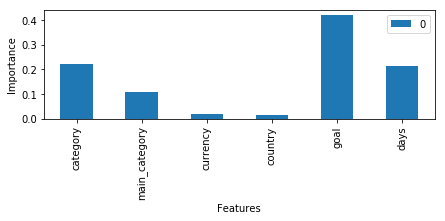

In [125]:
RF_clf = RandomForestClassifier(n_estimators=10, max_depth=None, criterion="gini",
                                                 min_samples_leaf=4, min_samples_split=4, random_state=1234)
RF_clf.fit(X_train, y_train)
print('訓練score=', RF_clf.score(X_train, y_train))
print("汎化score=", RF_clf.score(X_test, y_test))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
pd.DataFrame(RF_clf.feature_importances_, index=tree_df.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

## AdaBoost

訓練score= 0.6998531273740187
汎化score= 0.6871859975149911
[0.25466072 0.13109761 0.02935745 0.01859608 0.36996034 0.19632781]


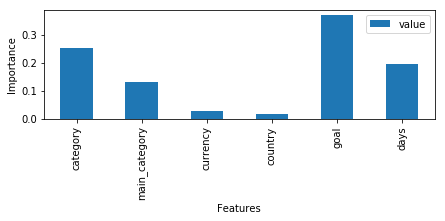

In [129]:
AB_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_split=4, min_samples_leaf=4, random_state=1234),
                         n_estimators=10, algorithm='SAMME')
AB_clf.fit(X_train, y_train)
print('訓練score=', AB_clf.score(X_train, y_train))
print("汎化score=", AB_clf.score(X_test, y_test))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(AB_clf.feature_importances_)
pd.DataFrame(AB_clf.feature_importances_, index=tree_df.columns, columns=['value']).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

## 線形モデルでのAdaBoost

In [128]:
linear_AB_clf = AdaBoostClassifier(base_estimator=SGDClassifier(loss="log", penalty="none", max_iter=100, fit_intercept=False), 
                         n_estimators=20, algorithm='SAMME')
clf.fit(X_train, y_train)
print('訓練score=', linear_AB_clf.score(X_train, y_train))
print("汎化score=", linear_AB_clf.score(X_test, y_test))

NotFittedError: This AdaBoostClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## GradientBoosting
- n_estimatorsを上げていけば訓練スコアと共に汎化スコアも上がる

In [ ]:
GB_clf = GradientBoostingClassifier(n_estimators=600, loss='deviance')
GB_clf.fit(X_train, y_train)
print('訓練score=', GB_clf.score(X_train, y_train))
print("汎化score=", GB_clf.score(X_test, y_test))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
pd.DataFrame(GB_clf.feature_importances_, index=tree_df.columns, columns=['value']).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()